In [1]:
from pyspark.sql.functions import *
import pyspark as ps
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
import numpy as np
import os
import json
import glob

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df capstone") \
            .getOrCreate()

spark

In [3]:
# dframe = spark.read.json('./data/mpd.slice.0-999.json', multiLine=True)
# playlist = dframe.head()[1]
# single_playlist = playlist[0]
# #column_names = single_playlist.__fields__


In [4]:
column_names = ['collaborative',
 'description',
 'duration_ms',
 'modified_at',
 'name',
 'num_albums',
 'num_artists',
 'num_edits',
 'num_followers',
 'num_tracks',
 'pid',
 'tracks']


In [5]:
path_to_json = "./data/"
json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

In [6]:
#file_list[:3]

## problem area -> 

In [7]:
list_of_frames = []
for file in file_list[:20]: 
    current_df = spark.read.json(file, multiLine=True)
    current_playlist = current_df.head()[1]
    current_pframe = pd.DataFrame(current_playlist, columns=column_names)
    list_of_frames.append(current_pframe)

In [8]:
result = pd.concat(list_of_frames)

In [9]:
result.set_index('pid', inplace=True)

In [10]:
df = result.drop('tracks', axis=1).copy()
df.drop('name', axis=1, inplace=True)
df.drop('description', axis=1, inplace=True)
df.drop('modified_at', axis=1, inplace=True)

In [15]:
# COLUMNS OF INTEREST ISOLATED INTO CLEAN FRAME IN 'df' VARIABLE:


In [11]:
df.to_csv('20k_playlists.csv')

In [12]:
## save result as pandas file for easy calling later

In [13]:
df

,collaborative,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks
pid,,,,,,,
0,false,11532414,47,37,6,1,52
1,false,11656470,23,21,5,1,39
2,false,14039958,51,31,18,1,64
3,false,28926058,107,86,4,1,126
4,false,4335282,16,16,7,2,17
...,...,...,...,...,...,...,...
115995,false,8983567,32,25,11,1,39
115996,true,5660735,19,17,16,1,20
115997,false,3765841,12,9,8,1,14


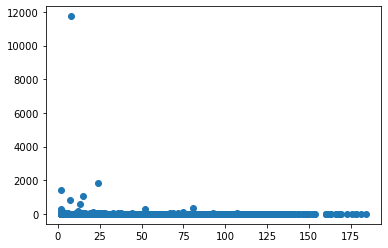

In [14]:
# comparing number of edits to number of followers. Data does not look interesting. 
plt.scatter(df.num_edits, df.num_followers)

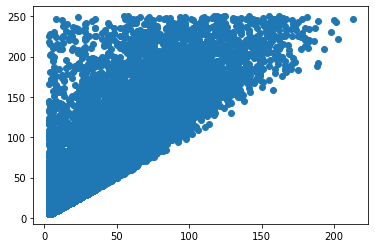

In [15]:
#comparing number of artists to number of tracks (playlist diversity?) - seems interesting, consistent ratio? 
plt.scatter(df.num_artists, df.num_tracks)
#explore plotting the line of completely diverse songs
#entropy of a group: think of a way to score the diversity numerically? (distance from the 1:1 ratio line, or, more simply: ratio of artists to tracks)

(array([5892., 4772., 3121., 1925., 1407.,  940.,  678.,  555.,  412.,
         298.]),
 array([  5. ,  29.5,  54. ,  78.5, 103. , 127.5, 152. , 176.5, 201. ,
        225.5, 250. ]),
 <BarContainer object of 10 artists>)

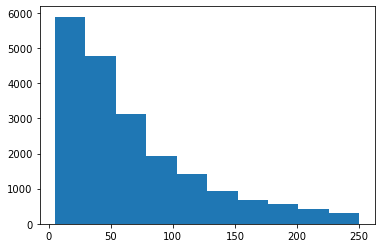

In [16]:
#looking at number of tracks
plt.hist(df.num_tracks)

(array([7.979e+03, 5.770e+03, 3.028e+03, 1.657e+03, 8.190e+02, 4.040e+02,
        2.050e+02, 1.020e+02, 3.000e+01, 6.000e+00]),
 array([  3.,  24.,  45.,  66.,  87., 108., 129., 150., 171., 192., 213.]),
 <BarContainer object of 10 artists>)

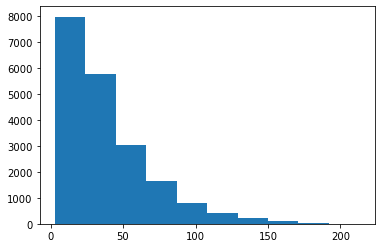

In [17]:
#looking at number of artists per playlist
plt.hist(df.num_artists)

In [18]:
df['diversity_ratio'] = df['num_artists'] / df['num_tracks']

In [19]:
df

,collaborative,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,diversity_ratio
pid,,,,,,,,
0,false,11532414,47,37,6,1,52,0.711538
1,false,11656470,23,21,5,1,39,0.538462
2,false,14039958,51,31,18,1,64,0.484375
3,false,28926058,107,86,4,1,126,0.682540
4,false,4335282,16,16,7,2,17,0.941176
...,...,...,...,...,...,...,...,...
115995,false,8983567,32,25,11,1,39,0.641026
115996,true,5660735,19,17,16,1,20,0.850000
115997,false,3765841,12,9,8,1,14,0.642857


In [38]:
df.to_csv('20k_playlists.csv')

(array([ 441.,  554.,  877., 1440., 2052., 2726., 3209., 3376., 2924.,
        2401.]),
 array([0.01327434, 0.1119469 , 0.21061947, 0.30929204, 0.4079646 ,
        0.50663717, 0.60530973, 0.7039823 , 0.80265487, 0.90132743,
        1.        ]),
 <BarContainer object of 10 artists>)

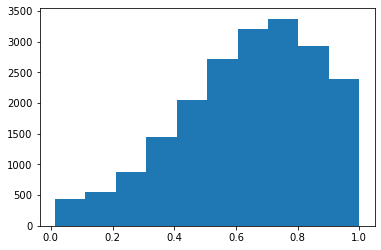

In [21]:
plt.hist(df.diversity_ratio)

In [22]:
df.corr()

,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,diversity_ratio
duration_ms,1.000000,0.892883,0.805262,0.601488,-0.001288,0.985038,-0.388490
num_albums,0.892883,1.000000,0.954827,0.670223,-0.000484,0.901493,-0.110367
num_artists,0.805262,0.954827,1.000000,0.661720,0.000307,0.818935,0.067262
num_edits,0.601488,0.670223,0.661720,1.000000,0.000100,0.604215,-0.052360
num_followers,-0.001288,-0.000484,0.000307,0.000100,1.000000,-0.000952,0.000648
num_tracks,0.985038,0.901493,0.818935,0.604215,-0.000952,1.000000,-0.389533
diversity_ratio,-0.388490,-0.110367,0.067262,-0.052360,0.000648,-0.389533,1.000000


<AxesSubplot:>

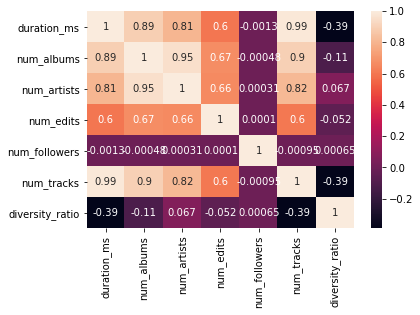

In [23]:
sn.heatmap(df.corr(), annot=True)

### planning: 
- null hypothesis: Playlist diversity ratio has no effect on number of followers
- can compare the diference between the "high follower" set and the "low follower" set to see if diversity ratio influences follower count
- t-test to see if you can confidently reject the null-hypothesis

In [26]:
less_than = df[df['num_followers'] < 10]
less_than

,collaborative,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,diversity_ratio
pid,,,,,,,,
0,false,11532414,47,37,6,1,52,0.711538
1,false,11656470,23,21,5,1,39,0.538462
2,false,14039958,51,31,18,1,64,0.484375
3,false,28926058,107,86,4,1,126,0.682540
4,false,4335282,16,16,7,2,17,0.941176
...,...,...,...,...,...,...,...,...
115995,false,8983567,32,25,11,1,39,0.641026
115996,true,5660735,19,17,16,1,20,0.850000
115997,false,3765841,12,9,8,1,14,0.642857


In [29]:
greater_equal = df[df['num_followers'] >= 10]
greater_equal

,collaborative,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,diversity_ratio
pid,,,,,,,,
223,false,29870133,106,76,37,10,120,0.633333
241,false,29003627,25,7,17,18,151,0.046358
255,false,6772221,28,25,3,22,32,0.781250
296,false,8320641,31,26,19,11,35,0.742857
365,false,29409896,114,90,18,15,128,0.703125
...,...,...,...,...,...,...,...,...
115594,false,5896162,27,11,7,21,32,0.343750
115638,false,15728788,35,15,5,13,65,0.230769
115825,false,4531957,19,17,2,27,24,0.708333


In [30]:
less_than_mean = less_than.diversity_ratio.mean()
less_than_mean

0.6396541269386848

In [31]:
greater_equal_mean = greater_equal.diversity_ratio.mean()
greater_equal_mean

0.6238787506983645

In [32]:
less_than_std = less_than.diversity_ratio.std()
less_than_std

0.22686081949319425

In [33]:
greater_equal_std = greater_equal.diversity_ratio.std()
greater_equal_std

0.24043472932460513

In [31]:
less_than_norm = stats.norm(less_than_mean, less_than_std)
greater_equal_norm = stats.norm(greater_equal_mean, greater_equal_std)

In [37]:
left_tail = less_than_norm.ppf(.025)
right_tail = less_than_norm.ppf(.975)


fig, ax = plt.subplots()
x = np.linspace(-0.25,1.5,100)
ax.plot(x, less_than_norm.pdf(x), color='blue')
ax.plot(x, greater_equal_norm.pdf(x), color='red')
ax.axvline(left_tail, color='blue', linestyle = 'dashed')
ax.axvline(right_tail, color='blue', linestyle='dashed')
ax.axvline(greater_equal_mean, color='red', linestyle='dashed')

NameError: name 'less_than_norm' is not defined

#### run scipy.stats t-test to get p-value that backs up rejecting the null hypothesis
#### check to see if the diversity_ratio is normally distributed?? If no, bootstrapping for CLT sampling means

In [36]:
plt.plot(x, df.diversity_ratio)

NameError: name 'x' is not defined